#### In this problem we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

Here, We are particularly interested in detecting faces in a given image.

#### To use the model first, we need to import the model and its supporting files for the model to function. 

We see the below steps to import the model.

### Import MobileNet model given in file `mn_model.py`

In [1]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/R9 Advanced Comp Vision')

In [3]:
### Import MobileNet model given in file `mn_model.py`

from mn_model import mn_model

Using TensorFlow backend.


### Import the BatchGenerator and SSDLoss functions in given files `face_generator.py`, `keras_ssd_loss` and `ssd_box_encode_decode_utils.py` as well, used in MobileNet model

In [4]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

face_generator.py:39: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87

In [0]:

import warnings
warnings.filterwarnings("ignore")

from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored
import matplotlib.pyplot as plt
import cv2

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm


## Set the parameters for the model

#### We need to customize the model parameters according to our problem as given below.

#### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
#### `Face` will be one class and everything else comes under other class (we can call it as `background`)

#### Set class_names = ["background", "face"]

In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

det_model_path = "./"

### Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 

#### To make the dataset available follow the steps given below.


1. Create a folder in your google drive for this project. 

2. Download the train and test dataset files given in .zip format into your drive folder you created for the project in step-1.

3. Set the project path variable according to the folders you created to use for this project in your google drive. 

      `project_path = "/content/drive/My Drive/DLCP/"`

4. Now, as we mount the drive the images will be available to use for training and testing but in zip format.

5. So, lets extract the images from the zipfiles by using the code given of zipfile module.







In [0]:
project_path = '/content/drive/My Drive/R9 Advanced Comp Vision/'

In [0]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [9]:
# Remove existing files and folders
!rm -r ./WIDER_train
!rm -r ./WIDER_val
!ls -l .

total 1826743
-rw------- 1 root root     436315 Jul  3 08:08  ACV_Project1_FaceDetector_Project_Brief.pdf
-rw------- 1 root root      72179 Jul  3 12:06  face_generator.py
-rw------- 1 root root      38083 Jul  3 12:06  face_generator.pyc
-rw------- 1 root root      13689 Jul  3 10:02  keras_layer_AnchorBoxes.py
-rw------- 1 root root      10566 Jul  3 10:03  keras_layer_AnchorBoxes.pyc
-rw------- 1 root root       2266 Jul  3 12:03  keras_layer_L2Normalization.py
-rw------- 1 root root       2905 Jul  3 12:04  keras_layer_L2Normalization.pyc
-rw------- 1 root root      11818 Jul  3 12:06  keras_ssd_loss.py
-rw------- 1 root root       8190 Jul  3 12:06  keras_ssd_loss.pyc
-rw------- 1 root root      36216 Jul  3 09:06  mn_model.py
-rw------- 1 root root      21354 Jul  3 09:08  mn_model.pyc
-rw------- 1 root root   17225924 Jul  5 18:59  mobilenet_1_0_224_tf.h5
-rw------- 1 root root   22767328 Jul  7 04:33  model_weights.hdf5
drwx------ 2 root root       4096 Jul  7 05:00  output_tes

In [0]:
import zipfile
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

In [12]:
# Validate creation of folders WIDER_train and WIDER_val
!ls -l

total 1825600
-rw------- 1 root root     436315 Jul  3 08:08  ACV_Project1_FaceDetector_Project_Brief.pdf
-rw------- 1 root root      72179 Jul  3 12:06  face_generator.py
-rw------- 1 root root      38083 Jul  3 12:06  face_generator.pyc
-rw------- 1 root root      13689 Jul  3 10:02  keras_layer_AnchorBoxes.py
-rw------- 1 root root      10566 Jul  3 10:03  keras_layer_AnchorBoxes.pyc
-rw------- 1 root root       2266 Jul  3 12:03  keras_layer_L2Normalization.py
-rw------- 1 root root       2905 Jul  3 12:04  keras_layer_L2Normalization.pyc
-rw------- 1 root root      11818 Jul  3 12:06  keras_ssd_loss.py
-rw------- 1 root root       8190 Jul  3 12:06  keras_ssd_loss.pyc
-rw------- 1 root root      36216 Jul  3 09:06  mn_model.py
-rw------- 1 root root      21354 Jul  3 09:08  mn_model.pyc
-rw------- 1 root root   17225924 Jul  5 18:59  mobilenet_1_0_224_tf.h5
-rw------- 1 root root   22767328 Jul  7 04:33  model_weights.hdf5
drwx------ 2 root root       4096 Jul  7 05:00  output_tes

### Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

#### Follow the below steps to get those labels available.


Load the  '' `wider_train_small.npy`'' file given to check the information given about the dataset. In this file you can see the information about each image in the dataset in a list with following elemets:
      

        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [0]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

data = np.load('./wider_train_small.npy').item()

# restore np.load for future normal usage
np.load = np_load_old

In [14]:
### Printed first element to check the above given information.

for key in data:
    print key
    print data[key]
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [0]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

x = np.load(train_data)

# restore np.load for future normal usage
np.load = np_load_old

### Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [16]:
# build the keras model
# this model is not retrained, we are doing it from scratch 

K.clear_session()
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

W0707 05:18:42.787611 140142326032256 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0707 05:18:42.791459 140142326032256 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0707 05:18:42.814975 140142326032256 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 05:18:42.817290 140142326032256 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W070

====> Model Specific data
====> Height, Width, Channels : 512 512 3


#### Write code to freeze all the layers in the above model with names not having ''`detection`'' word as prefix.

In [0]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model.layers:
  if('detection' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

### After making the model ready for transfer learning, load the weights of the model given in file ''`mobilenet_1_0_224_tf.h5`''

In [0]:
#The pre-trained weights must exist in the current folder
model.load_weights('mobilenet_1_0_224_tf.h5', by_name=True)

#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. Run the below code.

In [19]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


### Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [20]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=['accuracy'])

W0707 05:18:55.132266 140142326032256 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 05:18:55.152354 140142326032256 deprecation.py:323] From keras_ssd_loss.py:129: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0707 05:18:55.167152 140142326032256 deprecation.py:323] From keras_ssd_loss.py:76: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0707 05:18:55.188781 140142326032256 deprecation.py:323] From keras_ssd_loss.py:162: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


### Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.


We are using checkpoint to save the best model based on validation accuracy.

#### Write code for early_stopping and model_checkpoint layers. Using model.fit_generator train the model and save the best weight file.

In [0]:
# Remove existing model weights file
!rm model_weights.hdf5

In [0]:
model_checkpoint = ModelCheckpoint(filepath='model_weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

In [23]:
model.fit_generator(generator=train_generator,steps_per_epoch=128//32,epochs=10,callbacks=[model_checkpoint,early_stopping],validation_data=val_generator,validation_steps=60//32)

Epoch 1/10
4/4 [==============================] - 131s 33s/step - loss: 0.3628 - acc: 0.0700 - val_loss: 0.4186 - val_acc: 0.0418

Epoch 00001: val_acc improved from -inf to 0.04185, saving model to model_weights.hdf5
Epoch 2/10
4/4 [==============================] - 94s 23s/step - loss: 0.3138 - acc: 0.0718 - val_loss: 0.3889 - val_acc: 0.0373

Epoch 00002: val_acc did not improve from 0.04185
Epoch 3/10
4/4 [==============================] - 95s 24s/step - loss: 0.2786 - acc: 0.0718 - val_loss: 0.3527 - val_acc: 0.0340

Epoch 00003: val_acc did not improve from 0.04185
Epoch 4/10
4/4 [==============================] - 93s 23s/step - loss: 0.2663 - acc: 0.0711 - val_loss: 0.3573 - val_acc: 0.0325

Epoch 00004: val_acc did not improve from 0.04185
Epoch 5/10
4/4 [==============================] - 95s 24s/step - loss: 0.2594 - acc: 0.0718 - val_loss: 0.3066 - val_acc: 0.0350

Epoch 00005: val_acc did not improve from 0.04185
Epoch 6/10
4/4 [==============================] - 95s 24s/step

### Load the best saved model from above step and check predictions for test data using test_generator object to generate batches.

#### Write code in the below cell to load best saved model in the above step.

In [0]:
# Load the best model weights saved above
model.load_weights('model_weights.hdf5')

### Use the below function to plot the boundingbox in the test image to show the predictions.

In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename
  from keras.preprocessing import image
  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 256)).tolist()
  color_code = min(len(results), 256)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


#### Run the below code to create a folder with name output_test and get the predictions for the test images using model.predict()

In [0]:
# Remove existing files and folder
!rm -r output_test

In [0]:
!mkdir output_test

In [28]:
#from keras.preprocessing import image
#from matplotlib import pyplot as plt

test_size = 20
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for i in range(test_size):
    #print(i)
    X, y, filenames = next(test_generator)
    #print(filenames[i])
    y_pred = model.predict(X)
    y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


    np.set_printoptions(suppress=True)
    
    save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 45
('saved', './output_test/4_Dancing_Dancing_4_97.jpg')
total number of bbs: 5
('saved', './output_test/4_Dancing_Dancing_4_97_gt.jpg')
total number of bbs: 54
('saved', './output_test/49_Greeting_peoplegreeting_49_124.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_124_gt.jpg')
total number of bbs: 76
('saved', './output_test/20_Family_Group_Family_Group_20_696.jpg')
total number of bbs: 7
('saved', './output_test/20_Family_Group_Family_Group_20_696_gt.jpg')
total number of bbs: 43
('saved', './output_test/13_Interview_Interview_Sequences_13_779.jpg')
total number of bbs: 1
('saved', './output_test/13_Interview_Interview_Sequences_13_779_gt.jpg')
total number of bbs: 42
('saved', './output_test/57_Angler_peoplefishing_57_153.jpg')
total number of bbs: 1
('saved', './output_test/57_Angler_peoplefishing_57_153_gt.jpg')
total number of bbs: 97
('saved', './output_test/2_Demonstration_Demonstrators_2_188.jpg

<Figure size 432x288 with 0 Axes>

In the above step all the test images along with predictions are stored in output_test folder in this notebook environment. You can check the folder in Files section of the menu to left-side of screen in colab.

Each test image is used for predictions and is stored as 2 files.

one file is the original ground truth with <filename_gt.jpg>
second file is the prediction of the model on the image. with <filename.jpg>

### Visualize a test image to check predictions


#### Write code to show images: Using cv2.imshow() or matplotlib show any 3 test images and their predictions.

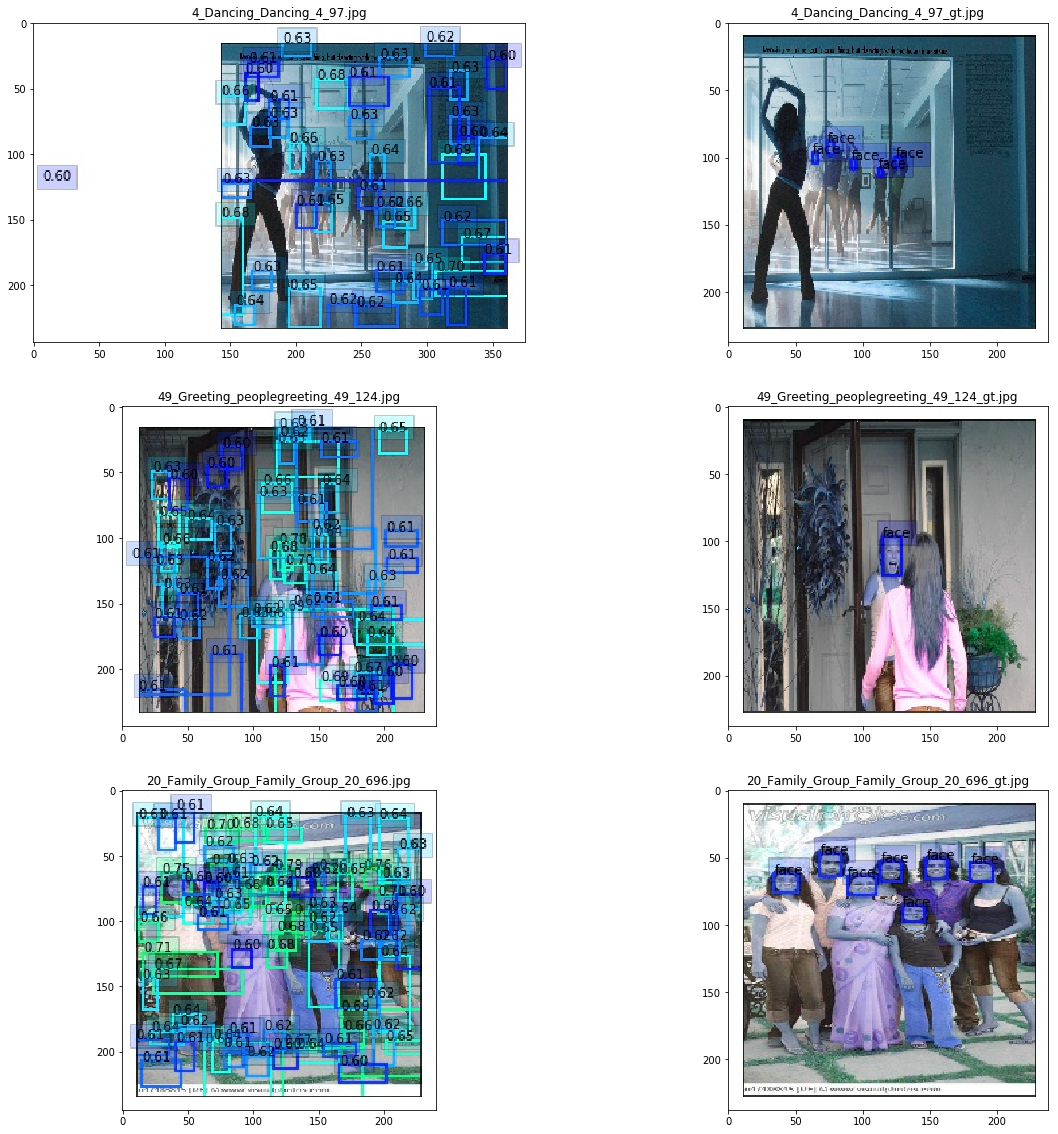

In [29]:
import os
files = os.listdir('./output_test/')

fig=plt.figure(figsize=(20, 20))
for i in range(6):
    img = cv2.imread('./output_test/' + files[i])
    fig.add_subplot(3, 2, i+1)
    plt.imshow(img)
    plt.title(files[i])
plt.show()